In [1]:
# inputFile = '/storage/user/ocerri/BPhysics/Combine/results/'
# inputFile += 'v5B0ratiocomb_CLN_blinded/higgsCombineBestfit.MultiDimFit.mH120.root'

card = 'cards/v5B0ratiocomb_CLN_blinded.root'
unblinded = False
rVal = 0.295 #use None for bestfit

varMods = {'B2DstCLNeig1': 0.0
          }

# Setup

## Imports

In [2]:
import sys, os, pickle, time, json, yaml, itertools, commands, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import numpy as np
import pandas as pd

In [3]:
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

Welcome to JupyROOT 6.12/07


In [4]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

In [5]:
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from combine_utilities import loadHisto4CombineFromRoot

## Directories

In [6]:
if 'inputFile' in locals().keys():
    outdir = os.path.dirname(inputFile)
else:
    outdir = card.replace('cards', 'results').replace('.root', '')
    
outdir += '/mvDistVar'
s = ''
for k,v in varMods.iteritems():
    s += '_'+k
    s += '{:.1f}'.format(v).replace('.', 'p')
outdir += s
print outdir
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    print 'Creating directory'

results/v5B0ratiocomb_CLN_blinded/mvDistVar_B2DstCLNeig10p0
Creating directory


# Run combine

Create the snapshot

In [7]:
channelMasking = ['AddTk_pm_mHad', 'B_pt', 'B_eta']
for n in ['Est_mu', 'M2_miss', 'mu_pt', 'Dst_pt']:
    for i in range(4):
        channelMasking.append(n+'_q2bin'+str(i))

if not unblinded:
    channelMasking += ['Unrolled_q2bin2', 'Unrolled_q2bin3']

if 'comb' in card:
    aux = []
    for c in ['low', 'mid', 'high']:
        for cm in channelMasking:
            aux.append('{}_{}'.format(c, cm))
    channelMasking = aux
maskStr = ','.join(['mask_{}=1'.format(c) for c in channelMasking])

In [8]:
if 'card' in locals().keys():
    cmd = 'cd ' + outdir + '; '
    cmd += 'combine -M MultiDimFit'
    cmd += ' --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic'
    cmd += ' -d /storage/user/ocerri/BPhysics/Combine/' + card
    if rVal is None:
        cmd += ' --setParameters r=0.295'
    else:
        cmd += ' --freezeParameters r --setParameters r={:.2f}'.format(rVal)

    if maskStr:
        cmd += ','+maskStr
    cmd += ' -n Fit'
    cmd += ' --saveWorkspace --verbose -1'
    print cmd
    status, output = commands.getstatusoutput(cmd)
    if status:
        print output
        raise
        
    inputFile = 'higgsCombineFit.MultiDimFit.mH120.root'

cd results/v5B0ratiocomb_CLN_blinded/mvDistVar_B2DstCLNeig10p0; combine -M MultiDimFit --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic -d /storage/user/ocerri/BPhysics/Combine/cards/v5B0ratiocomb_CLN_blinded.root --freezeParameters r --setParameters r=0.29,mask_low_AddTk_pm_mHad=1,mask_low_B_pt=1,mask_low_B_eta=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_low_mu_pt_q2bin0=1,mask_low_mu_pt_q2bin1=1,mask_low_mu_pt_q2bin2=1,mask_low_mu_pt_q2bin3=1,mask_low_Dst_pt_q2bin0=1,mask_low_Dst_pt_q2bin1=1,mask_low_Dst_pt_q2bin2=1,mask_low_Dst_pt_q2bin3=1,mask_low_Unrolled_q2bin2=1,mask_low_Unrolled_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_B_pt=1,mask_mid_B_eta=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bi

Run these commands in command line, otherwise it takes too long

In [9]:
cmd = 'combine -M FitDiagnostics'
cmd += ' -d ' + os.path.basename(inputFile)
cmd += ' --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic --X-rtd MINIMIZER_MaxCalls=1'
cmd += ' --snapshotName MultiDimFit'
cmd += ' -n Baseline'
cmd += ' --saveShapes'
cmd += ' --trackParameters rgx{.*}'

cmd2 = cmd + ' --setParameters ' + ','.join([k+'='+str(v) for k,v in varMods.iteritems()])
cmd2 = cmd2.replace('Baseline', 'Mods')

print 'cd ' + outdir + '; ' + cmd + '; ' + cmd2 +'; cd -'

cd results/v5B0ratiocomb_CLN_blinded/mvDistVar_B2DstCLNeig10p0; combine -M FitDiagnostics -d higgsCombineFit.MultiDimFit.mH120.root --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic --X-rtd MINIMIZER_MaxCalls=1 --snapshotName MultiDimFit -n Baseline --saveShapes --trackParameters rgx{.*}; combine -M FitDiagnostics -d higgsCombineFit.MultiDimFit.mH120.root --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic --X-rtd MINIMIZER_MaxCalls=1 --snapshotName MultiDimFit -n Mods --saveShapes --trackParameters rgx{.*} --setParameters B2DstCLNeig1=0.0; cd -


# Data loading

In [11]:
parsBase = pd.DataFrame(rtnp.root2array(outdir + '/fitDiagnosticsBaseline.root', treename='tree_prefit'))
parsMods = pd.DataFrame(rtnp.root2array(outdir + '/fitDiagnosticsMods.root', treename='tree_prefit'))
interestingColumns = [n for n in parsBase.columns if not (n.startswith('prop') or n.startswith('n_exp') or n.endswith('_In'))]

In [15]:
maxLen = 1 + np.max([len(n) for n in interestingColumns])
order = np.argsort([np.abs(parsBase[n].iloc[0]) for n in interestingColumns])

for iN in reversed(list(order)):
    n = interestingColumns[iN]
    name = n + ' '*(maxLen - len(n)) + ' '
    b = parsBase[n].iloc[0]
    m = parsMods[n].iloc[0]
    out = ''
    if m != b: out += '\033[1m\x1b[31m'
    out += name
    if b > 0: out += '+'
    out += '{:.2f} '.format(b)
    if m > 0: out += '+'
    out += '{:.2f}'.format(m)
    if m != b: out += '\x1b[0m'
    print out

B2DstCLNeig1            -3.86 0.00
B0pT                    -3.61 -3.61
B2DstCLNeig3            +2.98 +2.98
BmDstmHcBr              +2.75 +2.75
B2DstCLNeig2            +2.71 +2.71
DstmDspBr               +2.26 +2.26
BpPt                    -2.13 -2.13
BrB02DstDstpKst0        +1.79 +1.79
antiB0DstmHcBr          +1.52 +1.52
fDststWide              -1.50 -1.50
xsecpp2bbXlumiMu12_IP6  +1.27 +1.27
DstPiPiWidth            +1.24 +1.24
BrB02DstDsst            +1.22 +1.22
trkEff                  +0.96 +0.96
D2460_1StWidth          -0.95 -0.95
B2DstCLNR0              -0.90 -0.90
D2420_10Width           -0.71 -0.71
BrB02DstDs              +0.67 +0.67
BrB02DstDstpK0          +0.66 +0.66
muBr                    -0.62 -0.62
BrB02DstDpKst0          -0.60 -0.60
BrB02DstDst0Kp          -0.44 -0.44
TauDstPiBr              -0.41 -0.41
BrB02DstDs0st           +0.33 +0.33
DstmD0Br                +0.31 +0.31
BrB02DstDst0Kstp        +0.29 +0.29
DstPiBr                 -0.28 -0.28
tkPVfrac                +0.27

In [12]:
def getPostfitHistos(floc, histo_prefit):
    print 'Loading post-fit from:', floc
    fFitDiagnostics = rt.TFile(floc, 'READ')
    fd = fFitDiagnostics.shapes_prefit

    histo_postfit = {}
    for catregName in [k.GetTitle() for k in fd.GetListOfKeys()]:
        c = catregName.split('_')[0]
        if not c in histo_postfit.keys():
            histo_postfit[c] = {}
        regName = catregName[len(c)+1:]
        histo_postfit[c][regName] = {}

        for n, h in histo_prefit[c][regName].iteritems():
            if '__' in n:
                continue
            if 'data' in n:
                histo_postfit[c][regName]['data'] = h.Clone(h.GetName() + '_data')
            else:
                h_post = h.Clone(h.GetName() + '_postfit')
                h_fit = fd.Get(catregName+'/'+n)
                if not h_fit:
                    print n+' missing from '+c+' '+regName
                    continue
                for i in range(1, h_post.GetNbinsX()+1):
                    h_post.SetBinContent(i, h_fit.GetBinContent(i))
                    h_post.SetBinError(i, h_fit.GetBinError(i))

                histo_postfit[c][regName][n] = h_post

    return histo_postfit, fFitDiagnostics

In [13]:
histo_file_dir = '/storage/user/ocerri/BPhysics/data/_root/histos4combine/'
card_name = card.replace('cards/', '').replace('.root', '')
histo = {}
for c in ['low', 'mid', 'high']:
    print '---- Loading', c
    histo[c] = loadHisto4CombineFromRoot(histo_file_dir, card_name.replace('comb', c))

---- Loading low
---- Loading mid
---- Loading high


In [14]:
histoBase, fBase = getPostfitHistos(outdir + '/fitDiagnosticsBaseline.root', histo)
histoMods, fMods = getPostfitHistos(outdir + '/fitDiagnosticsMods.root', histo)

Loading post-fit from: results/v5B0ratiocomb_CLN_blinded/mvDistVar_B2DstCLNeig10p0/fitDiagnosticsBaseline.root
BmDstmHc missing from mid Dst_pt_q2bin0
DstmD0 missing from mid Dst_pt_q2bin0
BmDstmHc missing from mid Est_mu_q2bin0
DstmD0 missing from mid Est_mu_q2bin0
BmDstmHc missing from mid M2_miss_q2bin0
DstmD0 missing from mid M2_miss_q2bin0
BmDstmHc missing from mid Unrolled_q2bin0
DstmD0 missing from mid Unrolled_q2bin0
BmDstmHc missing from mid mu_pt_q2bin0
DstmD0 missing from mid mu_pt_q2bin0
BpDstmHc missing from high AddTk_mm_mHad
DstmD0 missing from high Dst_pt_q2bin0
DstmD0 missing from high Est_mu_q2bin0
DstmD0 missing from high M2_miss_q2bin0
DstmD0 missing from high Unrolled_q2bin0
DstmD0 missing from high mu_pt_q2bin0
BmDstmHc missing from low AddTk_pp_mHad
BmDstmHc missing from mid AddTk_pp_mHad
Loading post-fit from: results/v5B0ratiocomb_CLN_blinded/mvDistVar_B2DstCLNeig10p0/fitDiagnosticsMods.root
BmDstmHc missing from mid Dst_pt_q2bin0
DstmD0 missing from mid Dst_pt

# Draw plots

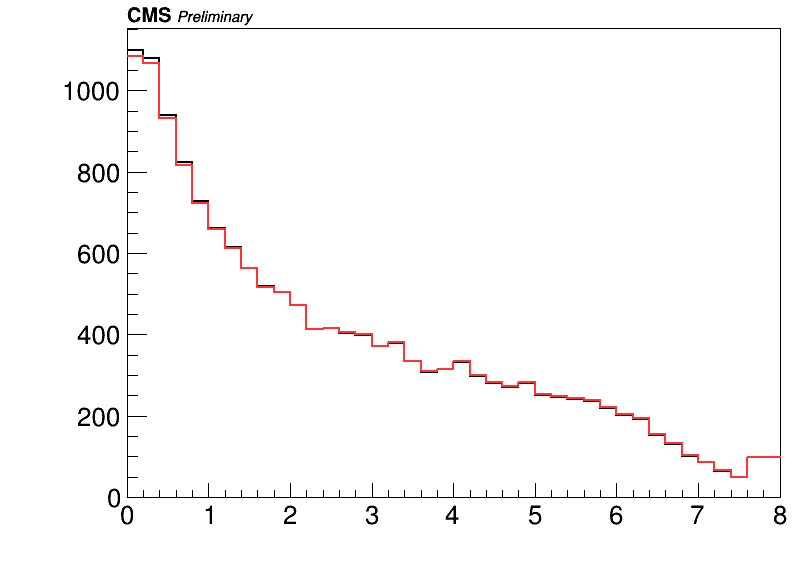

In [16]:
h1 = histoBase['low']['M2_miss_q2bin3']['total']
h2 = histoMods['low']['M2_miss_q2bin3']['total']
h2.SetLineColor(std_color_list[1])

c = drawOnCMSCanvas(CMS_lumi, [h1, h2], 'same')

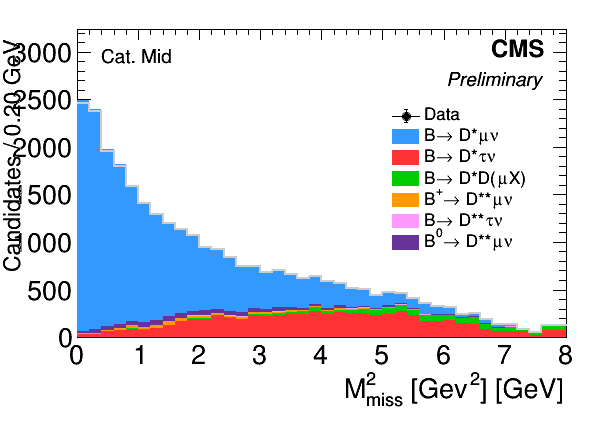

In [21]:
cAux = plot_SingleCategory(CMS_lumi, histoBase['mid']['M2_miss_q2bin3'], xtitle='M^{2}_{miss} [Gev^{2}]',
                           draw_pulls=False,
                           addText='Cat. Mid', logy=False, legBkg=True,
                           procOrder = ['tau', 'DstD', 'Dstst', 'mu'], maskData=True,
                           min_y=0, tag='midM2miss', legLoc=[0.65, 0.4, 0.9, 0.75])

h2 = histoMods['mid']['M2_miss_q2bin3']['total']
h2.SetLineColor(rt.kGray)
h2.Draw('same')
cAux.leg